# Congressional Voting Data Set

Congressional Voting party based on different questions on specific topics.

_Source_: https://www.kaggle.com/competitions/184-702-tu-ml-ws-24-congressional-voting/data

Group 18 Members:

- Clara Pichler, 11917694
- Hannah Knapp, 11901857 
- Sibel Toprakkiran, 09426341

### Overview

1. Introduction
- Requirements & Dependencies
- Loading in the Data Set

2. Preprocessing

3. Classification
- SVM
- Random Forest
- Multilayer Perceptron

4. Analysis of Performance

## Introduction 

### Requirements & Dependencies

This project was created using Python 3.12.5 The exact versions of the dependencies can be installed with the following command.

In [411]:
%pip install -r requirements.txt -q
%pip install tpot
%pip install torch


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [412]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

## Loading Data

In [413]:
df_voting = pd.read_csv('data/CongressionalVotingID.shuf.lrn.csv')

### Data Description

In [414]:
display(df_voting.head(5))
df_voting.info(verbose=True)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,democrat,y,n,y,n,y,y,y,n,y,y,n,n,y,y,n,unknown
1,86,democrat,n,n,y,n,y,y,n,n,n,y,y,y,y,y,n,y
2,264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
3,258,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,unknown,y
4,381,democrat,y,y,y,n,n,y,unknown,y,y,n,y,n,y,n,y,y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      218 non-null    int64 
 1   class                                   218 non-null    object
 2   handicapped-infants                     218 non-null    object
 3   water-project-cost-sharing              218 non-null    object
 4   adoption-of-the-budget-resolution       218 non-null    object
 5   physician-fee-freeze                    218 non-null    object
 6   el-salvador-aid                         218 non-null    object
 7   religious-groups-in-schools             218 non-null    object
 8   anti-satellite-test-ban                 218 non-null    object
 9   aid-to-nicaraguan-contras               218 non-null    object
 10  mx-missile                              218 non-null    object
 11  immigr

This data set has 218 entries and 18 attributes. The target value of this data set is class so what party the people are voting for in congress. We want in this classification task to predict based on the questions voters answered with either yes "y" or no "n". So the rest of the attributes are all binary data. There are no missing values per se but some questions were answered with unkown so we have to look how we want to deal with this missing values. 

Index(['ID', 'class', 'handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-crporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa'],
      dtype='object')

41.74311926605505

58.256880733944946

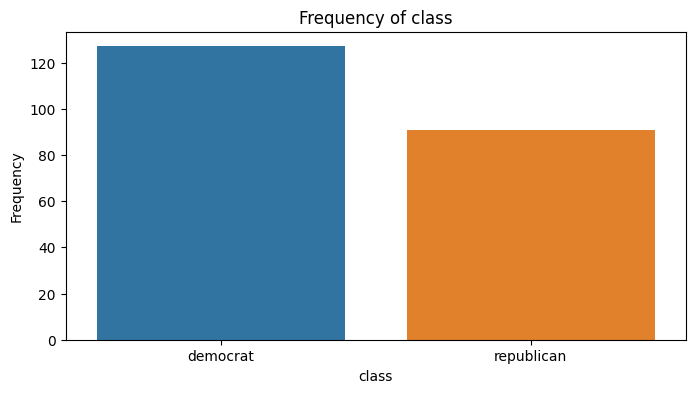

In [415]:
display(df_voting.columns)

display(len(df_voting[df_voting['class']=='republican'])/len(df_voting['class'])*100)
display(len(df_voting[df_voting['class']=='democrat'])/len(df_voting['class'])*100)

plt.figure(figsize=(8, 4))
sns.countplot(x='class', hue='class', data=df_voting)
plt.title('Frequency of class')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

From the frequency table we can see that there are more democrats than republicans in the data set.

handicapped-infants,n,unknown,y,All
class,,,,
democrat,41,3,83,127
republican,68,1,22,91
All,109,4,105,218


water-project-cost-sharing,n,unknown,y,All
class,,,,
democrat,57,15,55,127
republican,33,13,45,91
All,90,28,100,218


adoption-of-the-budget-resolution,n,unknown,y,All
class,,,,
democrat,8,6,113,127
republican,79,2,10,91
All,87,8,123,218


physician-fee-freeze,n,unknown,y,All
class,,,,
democrat,117,5,5,127
republican,2,1,88,91
All,119,6,93,218


el-salvador-aid,n,unknown,y,All
class,,,,
democrat,100,6,21,127
republican,4,1,86,91
All,104,7,107,218


religious-groups-in-schools,n,unknown,y,All
class,,,,
democrat,69,5,53,127
republican,7,1,83,91
All,76,6,136,218


anti-satellite-test-ban,n,unknown,y,All
class,,,,
democrat,25,4,98,127
republican,68,3,20,91
All,93,7,118,218


aid-to-nicaraguan-contras,n,unknown,y,All
class,,,,
democrat,17,3,107,127
republican,72,9,10,91
All,89,12,117,218


mx-missile,n,unknown,y,All
class,,,,
democrat,27,7,93,127
republican,80,1,10,91
All,107,8,103,218


immigration,n,unknown,y,All
class,,,,
democrat,71,2,54,127
republican,45,1,45,91
All,116,3,99,218


synfuels-crporation-cutback,n,unknown,y,All
class,,,,
democrat,61,6,60,127
republican,73,4,14,91
All,134,10,74,218


education-spending,n,unknown,y,All
class,,,,
democrat,103,11,13,127
republican,11,7,73,91
All,114,18,86,218


superfund-right-to-sue,n,unknown,y,All
class,,,,
democrat,83,8,36,127
republican,9,8,74,91
All,92,16,110,218


crime,n,unknown,y,All
class,,,,
democrat,82,5,40,127
republican,2,6,83,91
All,84,11,123,218


duty-free-exports,n,unknown,y,All
class,,,,
democrat,41,6,80,127
republican,75,8,8,91
All,116,14,88,218


export-administration-act-south-africa,n,unknown,y,All
class,,,,
democrat,4,41,82,127
republican,25,13,53,91
All,29,54,135,218


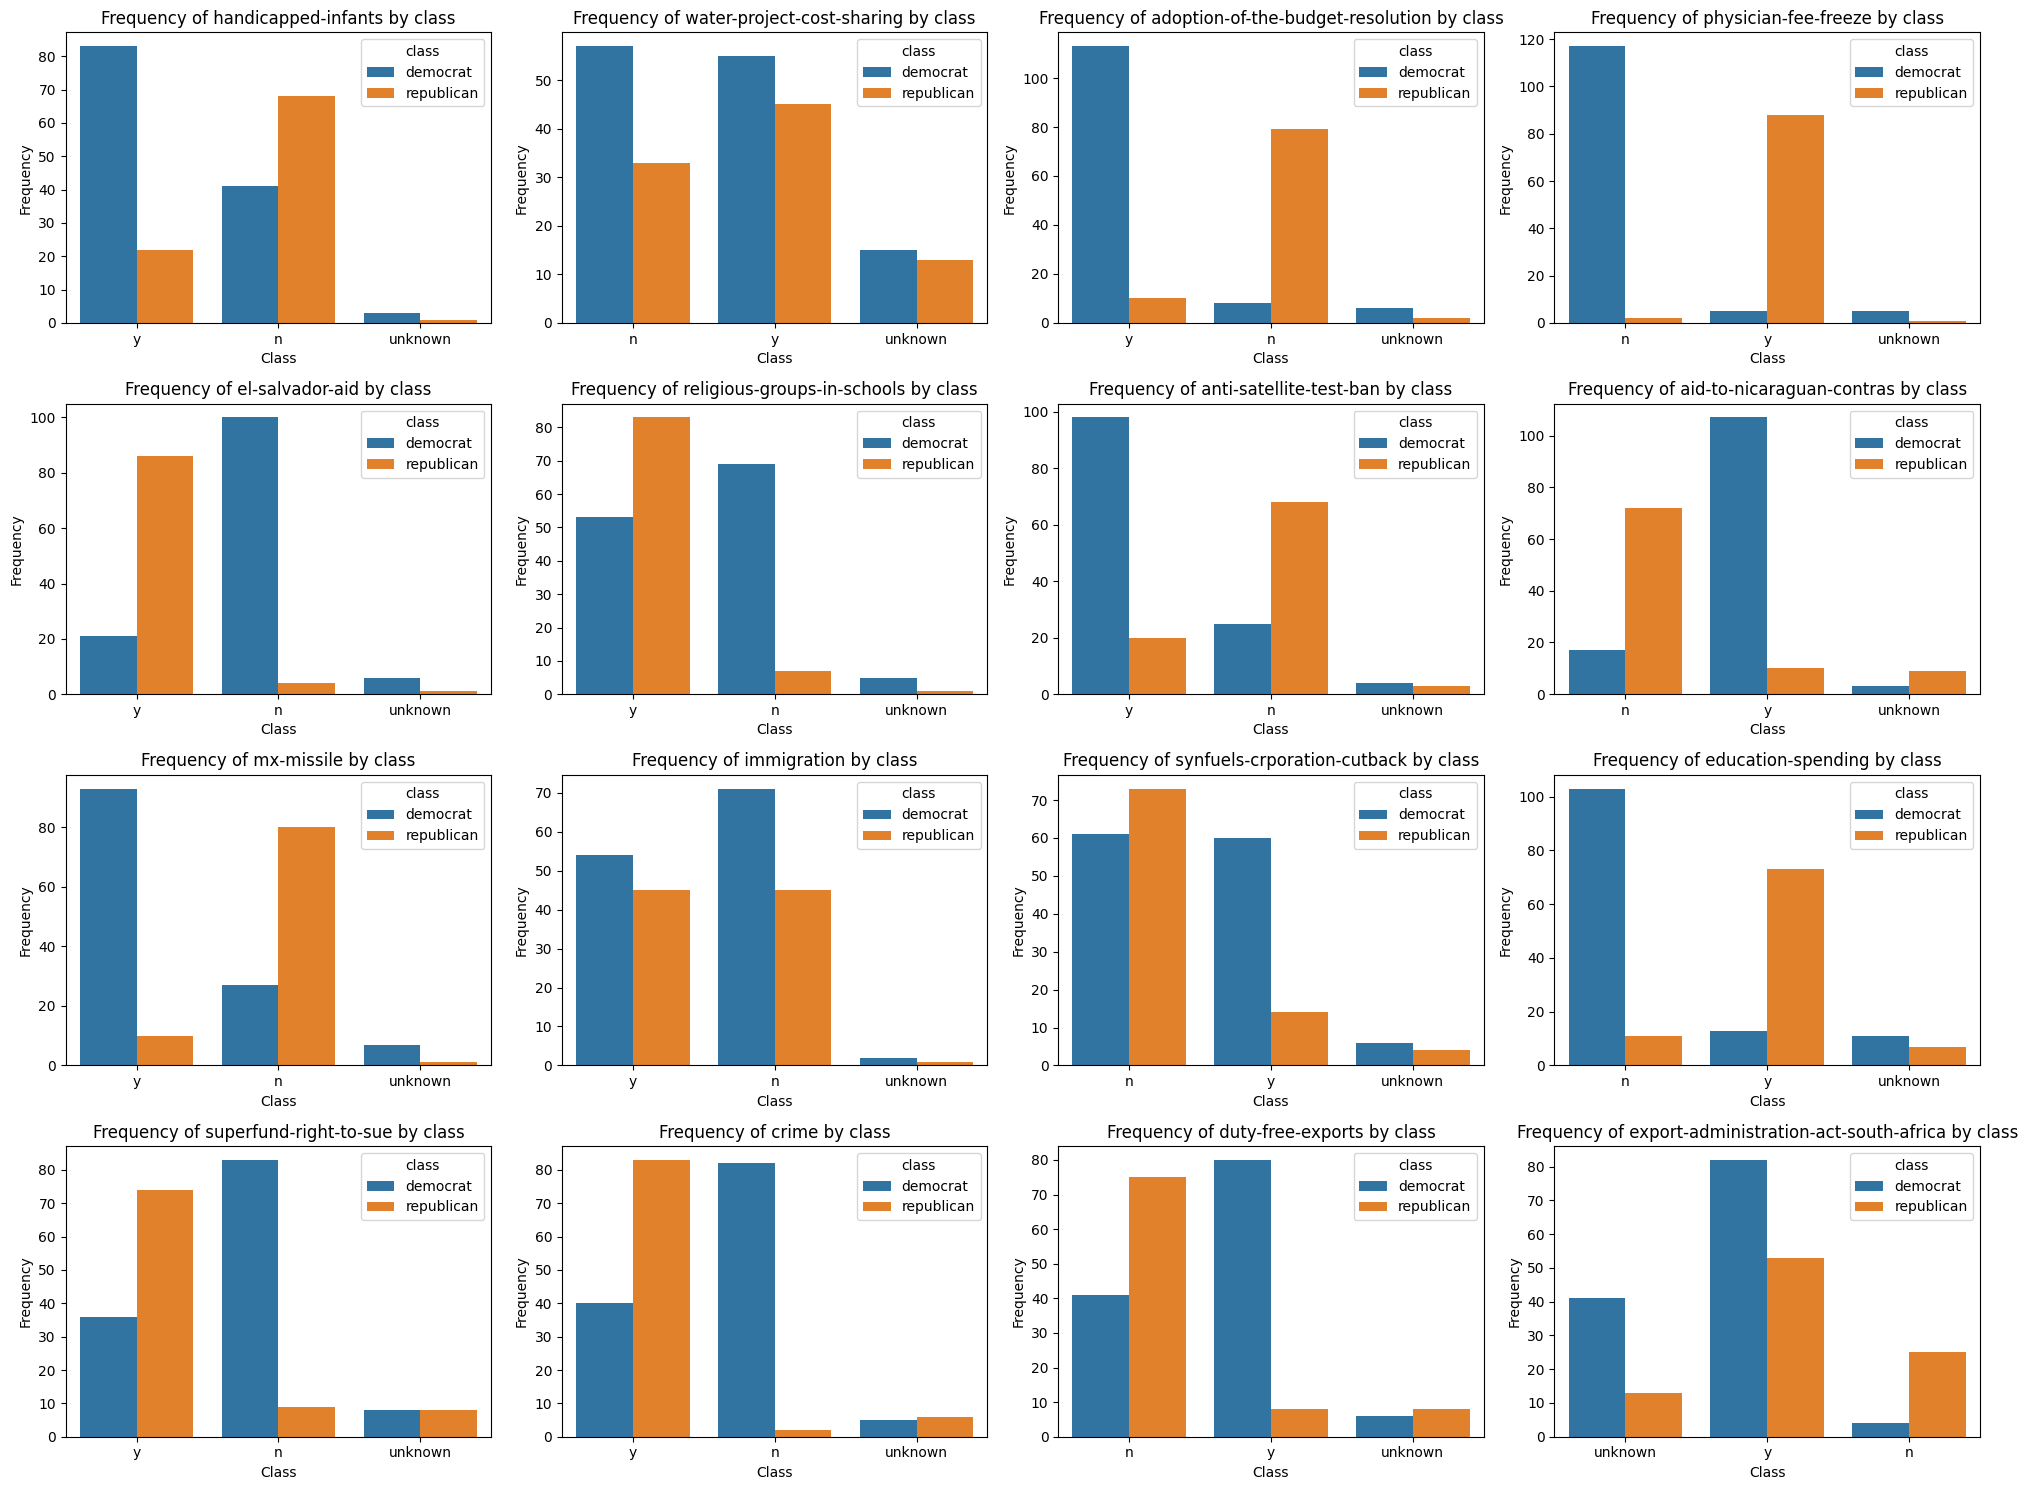

In [416]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

for j, i in enumerate(df_voting.columns[2:]):  # Limits to 16 columns
    contingency_table = pd.crosstab(index=df_voting['class'], columns=df_voting[i], margins=True)
    display(contingency_table)
    
    sns.countplot(x=i, hue='class', data=df_voting, ax=axes[j])
    axes[j].set_title(f'Frequency of {i} by class')
    axes[j].set_xlabel('Class')
    axes[j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

From the contingency tables we can get a grasp which attributes might indicate the best how an answer to a specific question could predict the class of the voter. For example adoption-of-the-budget-resolution was highly answered with "no" by republicans and "yes" by democrats while physician-fee-freeze was highly answered with "no" by democrats and "yes by republicans. Some questions are nearly balanced out and are harder to determine if the voter is going to vote democrat or republican. E.g. synfuels-crporation-cutback.

<AxesSubplot:>

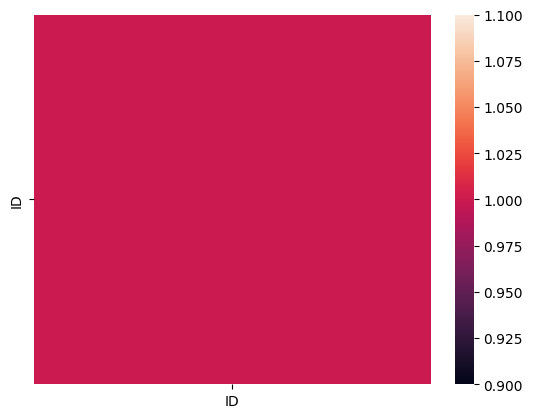

In [417]:
corr = df_voting.corr(method='pearson', numeric_only=True)
sns.heatmap(corr)

## Pre processing

We want to use for our data sets these three clasifiers:
1. Random Forrests
2. Support Vector Machines
3. Multilayer Perceptron

The classifier 1. could handle our missing value 'unknown' but for the classifiers 2. and 3. we need fully numeric data. So we change democrat to 0 and republican to 1 and n to 0, y to 1. In the next step we choose how to handle the missing value.

### Encoding

In [418]:
df_voting = df_voting.replace("democrat", 0).replace("republican", 1). replace("n", 0).replace("y", 1).replace("unknown", np.nan)

display(df_voting)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0
214,184,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0



### Handeling missing values

We will try different versions:

- keep the missing values as category
- impute missing values with median
- impute missing values with MICE

Multiple Imputation by Chained Equations (MICE) is a method of dealing with missing data in datasets. The procedure imputes missing data in a dataset through an iterative series of predictive models. In each iteration, each specified variable in the dataset is imputed using the other variables in the datase.

The MICE Imputation will later be part of our pipeline and will be done after splitting the data to prevent data leakage

ID                                         0
class                                      0
handicapped-infants                        4
water-project-cost-sharing                28
adoption-of-the-budget-resolution          8
physician-fee-freeze                       6
el-salvador-aid                            7
religious-groups-in-schools                6
anti-satellite-test-ban                    7
aid-to-nicaraguan-contras                 12
mx-missile                                 8
immigration                                3
synfuels-crporation-cutback               10
education-spending                        18
superfund-right-to-sue                    16
crime                                     11
duty-free-exports                         14
export-administration-act-south-africa    54
dtype: int64

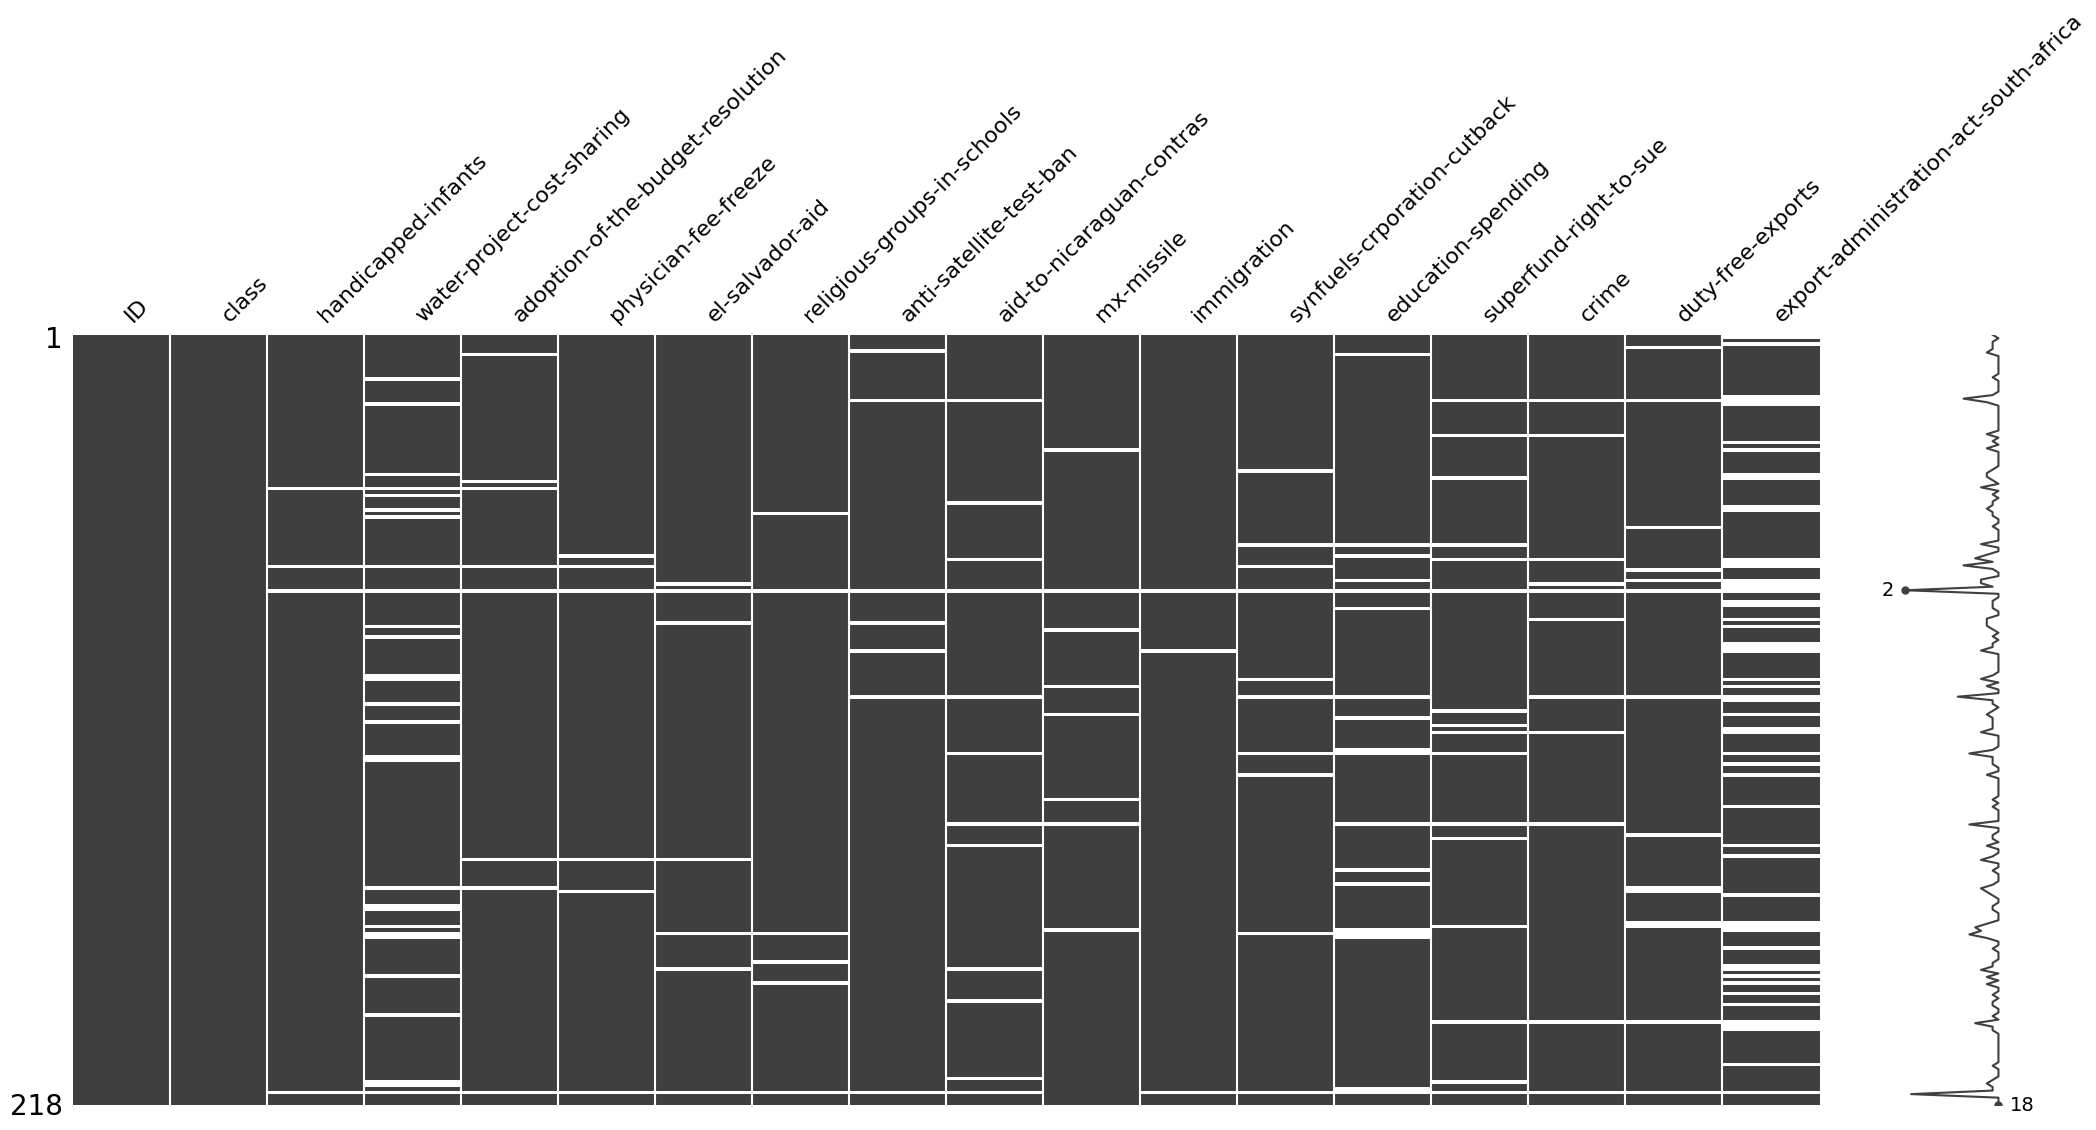

In [419]:
msno.matrix(df_voting)
df_voting.isna().sum()

There are some rows where we have in nearly all columns a missing value so we will delete these rows. We have a lot of missing values in the last column but not more than half so lets keep the column.

In [420]:
missing_values = df_voting.isnull().sum(axis=1)

df_voting = df_voting.drop(missing_values[missing_values > 10].index)

In [421]:
df_voting_keep_unknown = df_voting.copy().replace(np.nan, 2)

df_voting_impute_median = df_voting.copy().fillna(df_voting.median())

display(df_voting)
display(df_voting_keep_unknown)
display(df_voting_impute_median)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,NaN
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,NaN,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,1.0
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,86,0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,264,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,258,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,381,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,377,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
213,209,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
215,309,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
216,348,1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


## Classification - Holdout

Goal is to predict the target variable 'Class'

In [492]:
X_voting = df_voting.drop(['ID', 'class'], axis=1)
y_voting = df_voting['class']

#X_voting = df_voting_keep_unknown.drop(['ID', 'class'], axis=1)
#y_voting = df_voting_keep_unknown['class']

#X_voting = df_voting_impute_median.drop(['ID', 'class'], axis=1)
#y_voting = df_voting_impute_median['class']

X_missing = X_voting[X_voting.isnull().any(axis=1)]
X_not_missing = X_voting.dropna()

y_missing = y_voting[X_missing.index]
y_not_missing = y_voting[X_not_missing.index]

X_voting_train, X_voting_test, y_voting_train, y_voting_test = train_test_split(X_not_missing, y_not_missing, test_size=0.465, random_state=42, stratify=y_not_missing)
#X_voting_train, X_voting_test, y_voting_train, y_voting_test = train_test_split(X_not_missing, y_not_missing, test_size=0.25, random_state=42, stratify=y_not_missing)

X_voting_train = pd.concat([X_voting_train, X_missing])
y_voting_train = pd.concat([y_voting_train, y_missing])

In [481]:
from sklearn.base import BaseEstimator, TransformerMixin

class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, max_iter=10):
        self.max_iter = max_iter
        self.imputer = IterativeImputer(max_iter=self.max_iter)
    
    def fit(self, X, y=None):
        self.columns_ = X.columns
        self.imputer.fit(X)
        return self
    
    def transform(self, X, y=None):
        X_imputed = pd.DataFrame(self.imputer.transform(X), columns=X.columns)
        return X_imputed

In [482]:
class IQRFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self

    def transform(self, X, y=None):
        X_filtered = X.copy()
        for col in X_filtered.columns:
            Q1 = X_filtered[col].quantile(0.25)
            Q3 = X_filtered[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.threshold * IQR
            upper_bound = Q3 + self.threshold * IQR

            X_filtered[col] = np.where((X_filtered[col] < lower_bound), lower_bound, X_filtered[col])
            X_filtered[col] = np.where((X_filtered[col] > upper_bound), upper_bound, X_filtered[col])
        return X_filtered

In [483]:
def build_pipeline(classifier, search=0):
    if search == 0:
        return Pipeline(steps=[
            ('MICE', MICEImputer(max_iter = 25)),
            ('iqr_filter', IQRFilter(threshold=1.5)),
            ('scaler', StandardScaler()),  
            # ('feature_selection', SelectKBest(score_func=f_classif, k=3)),  
            ('classifier', classifier),  
        ])
    
    return Pipeline(steps=[
            ('MICE', MICEImputer(max_iter = 25)),
            ('iqr_filter', IQRFilter(threshold=1.5)),
            ('scaler', StandardScaler()),  
            # ('feature_selection', SelectKBest(score_func=f_classif, k=3)),  
            ('classifier', search), 
        ])

These functions are our preprocessing steps for the training set and where we will also then train our model. The following function will give us the Model Performance for our Classifiers.

In [484]:
def evaluate_classification(model, X_test, y_test, pipeline=None):
    
    target_names = ['democrat', 'republican']
    
    if pipeline:
        #print("parameters: ", pipeline.named_steps['classifier'].get_params(),"\n")
        predictions = pipeline.predict(X_test)

    else:
        #print("parameters: ", model.get_params(),"\n")
        predictions = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1, target_names=target_names))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    
    return accuracy

### Random Forest

In [485]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['log2', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [486]:
rf_pip = build_pipeline(RandomForestClassifier(), RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1))

In [493]:
rf_pip.fit(X_voting_train, y_voting_train)

Pipeline(steps=[('MICE', MICEImputer(max_iter=25)), ('iqr_filter', IQRFilter()),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                                         'max_depth': [10, 20,
                                                                       30, 40,
                                                                       50, 60,
                                                                       70, 80,
                                                                       90, 100,
                                                                       110,
                                                                       None],
                                                         'max_features': ['log2',
                                                                          'sqrt'],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4],
                                                         'min_samples_split': [2,
                                                                               5,
                                                                               10],
                                                         'n_estimators': [200,
                                                                          400,
                                                                          600,
                                                                          800,
                                                                          1000,
                                                                          1200,
                                                                          1400,
                                                                          1600,
                                                                          1800,
                                                                          2000]},
                                    random_state=42))])

In [494]:
rf_random = rf_pip.named_steps['classifier']

In [495]:
print("Best parameter: ", rf_random.best_params_,"\n")
print('Best score for training data:', rf_random.best_score_,"\n") 

Best parameter:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 90, 'bootstrap': False} 

Best score for training data: 0.9506172839506174 



In [498]:
rf_model = build_pipeline(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_voting_train, y_voting_train)

Pipeline(steps=[('MICE', MICEImputer(max_iter=25)), ('iqr_filter', IQRFilter()),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [497]:
base_accuracy = evaluate_classification(rf_model, X_voting_test, y_voting_test)
    
best_model_rf = rf_random.best_estimator_

random_accuracy = evaluate_classification(best_model_rf,X_voting_test, y_voting_test, rf_pip)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 98.15%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      1.00      0.98        26
  republican       1.00      0.96      0.98        28

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:
[[26  0]
 [ 1 27]]
Model Performance
Accuracy = 98.15%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      1.00      0.98        26
  republican       1.00      0.96      0.98        28

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

Confusion Matrix:
[[26  0]
 [ 1 27]]
Improvement of 0.00%.


In [532]:
random_1_pip = build_pipeline(RandomForestClassifier(n_estimators = 1000, max_features = 'log2', max_depth = 500, min_samples_split = 200, min_samples_leaf = 200, bootstrap = False))
random_1_pip.fit(X_voting_train, y_voting_train)

random_2_pip = build_pipeline(RandomForestClassifier(n_estimators = 800, max_features = 'sqrt', max_depth = 65, min_samples_leaf = 30, bootstrap = True, criterion='log_loss'))
random_2_pip.fit(X_voting_train, y_voting_train)

print(evaluate_classification(random_1_pip, X_voting_test, y_voting_test, random_1_pip))
print(evaluate_classification(random_2_pip, X_voting_test, y_voting_test, random_2_pip))

Model Performance
Accuracy = 48.15%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.48      1.00      0.65        26
  republican       1.00      0.00      0.00        28

    accuracy                           0.48        54
   macro avg       0.74      0.50      0.33        54
weighted avg       0.75      0.48      0.31        54

Confusion Matrix:
[[26  0]
 [28  0]]
0.48148148148148145
Model Performance
Accuracy = 96.30%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.93      1.00      0.96        26
  republican       1.00      0.93      0.96        28

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54

Confusion Matrix:
[[26  0]
 [ 2 26]]
0.9629629629629629


Results from different Pre-processing steps to see which performs best:

- model with unknown as category

Accuracy: 98.15%

- model with median imputation 

Accuracy: 98.15%

- model with mice imputation

Accuracy: 98.15%

Results from different Parameter combinations for the data set with MICE imputation

base:
- Accuracy = 94.55%

random 1:
- Accuracy = 49.09%

random 2:
- Accuracy = 92.73%

best:
- Accuracy = 98.15%

### Support Vector Machines

Support Vector Machines transform the feature space into a higher-dimensional space to seperate classes. They have the advantages of being effective in high dimensional spaces and it is still effective in cases where number of dimensions is greater than the number of samples. It uses a subset of training points (support vectors) in the decision function, so it is also memory efficient.

First we will tune the hyperparameters using grid search and cross validation.

In [500]:
params_grid_svm = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 0.1, 1, 5], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2, 3, 4]}
]

svm_pip = build_pipeline(SVC(), GridSearchCV(SVC(), params_grid_svm, cv=5))

Now to train our SVM model.

In [501]:
svm_pip.fit(X_voting_train, y_voting_train)

Pipeline(steps=[('MICE', MICEImputer(max_iter=25)), ('iqr_filter', IQRFilter()),
                ('scaler', StandardScaler()),
                ('classifier',
                 GridSearchCV(cv=5, estimator=SVC(),
                              param_grid=[{'C': [1, 10, 100, 1000],
                                           'gamma': [0.001, 0.0001, 0.1, 1, 5],
                                           'kernel': ['rbf']},
                                          {'C': [1, 10, 100, 1000],
                                           'kernel': ['linear']},
                                          {'C': [1, 10, 100, 1000],
                                           'degree': [2, 3, 4],
                                           'kernel': ['poly']}]))])

In [502]:
svm_model = svm_pip.named_steps['classifier']

In [503]:
print("Best parameter: ", svm_model.best_params_,"\n")
print('Best score for training data:', svm_model.best_score_,"\n") 

best_model_svm = svm_model.best_estimator_

Best parameter:  {'C': 1, 'kernel': 'linear'} 

Best score for training data: 0.968939393939394 



In [504]:
base_svm_pip = build_pipeline(SVC(kernel='linear'))
base_svm_pip.fit(X_voting_train, y_voting_train)

svm_voting_accuracy = evaluate_classification(base_svm_pip, X_voting_test, y_voting_test)
svm_voting_accuracy_best = evaluate_classification(best_model_svm, X_voting_test, y_voting_test, svm_pip)

print('Improvement of {:0.2f}%.'.format( 100 * (svm_voting_accuracy_best - svm_voting_accuracy) / svm_voting_accuracy))

Model Performance
Accuracy = 92.59%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.92      0.92      0.92        26
  republican       0.93      0.93      0.93        28

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54

Confusion Matrix:
[[24  2]
 [ 2 26]]
Model Performance
Accuracy = 92.59%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.92      0.92      0.92        26
  republican       0.93      0.93      0.93        28

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54

Confusion Matrix:
[[24  2]
 [ 2 26]]
Improvement of 0.00%.


In [533]:
svm_1_pip = build_pipeline(SVC(C=1000, gamma=0.001, kernel='rbf'))
svm_1_pip.fit(X_voting_train, y_voting_train)

svm_2_pip = build_pipeline(SVC(C=1000, kernel='linear', probability=True, random_state=42))
svm_2_pip.fit(X_voting_train, y_voting_train)

print(evaluate_classification(svm_1_pip, X_voting_test, y_voting_test, svm_1_pip))
print(evaluate_classification(svm_2_pip, X_voting_test, y_voting_test, svm_2_pip))

Model Performance
Accuracy = 94.44%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      0.92      0.94        26
  republican       0.93      0.96      0.95        28

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54

Confusion Matrix:
[[24  2]
 [ 1 27]]
0.9444444444444444
Model Performance
Accuracy = 92.59%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.92      0.92      0.92        26
  republican       0.93      0.93      0.93        28

    accuracy                           0.93        54
   macro avg       0.93      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54

Confusion Matrix:
[[24  2]
 [ 2 26]]
0.9259259259259259


Results from different Pre-processing steps to see which performs best:

- model with unknown as category

Accuracy: 96.30%

- model with median imputation 

Accuracy: 96.30%

- model with mice imputation

Accuracy: 92.59%

Results from different Parameter combinations for the data set with MICE imputation

base:
- Accuracy = 92.73%

svm 1:
- Accuracy = 94.55%

svm 2:
- Accuracy = 92.73%

best:
- Accuracy = 92.73%

### Multilayer Perceptron

In [506]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (10,20,20,25)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1, 0.5],
    'max_iter': [2000, 3000, 5000, 7000],
    'learning_rate': ['constant','adaptive'],
}

In [507]:
mlp_pip = build_pipeline(MLPClassifier(), RandomizedSearchCV(MLPClassifier(), param_distributions=param_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1, verbose=0))
mlp_pip.fit(X_voting_train, y_voting_train)

Pipeline(steps=[('MICE', MICEImputer(max_iter=25)), ('iqr_filter', IQRFilter()),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomizedSearchCV(cv=3, estimator=MLPClassifier(), n_iter=100,
                                    n_jobs=-1,
                                    param_distributions={'activation': ['tanh',
                                                                        'relu',
                                                                        'logistic'],
                                                         'alpha': [0.0001, 0.05,
                                                                   0.1, 0.5],
                                                         'hidden_layer_sizes': [(50,
                                                                                 50,
                                                                                 50),
                                                                                (50,
                                                                                 100,
                                                                                 50),
                                                                                (100,),
                                                                                (10,
                                                                                 20,
                                                                                 20,
                                                                                 25)],
                                                         'learning_rate': ['constant',
                                                                           'adaptive'],
                                                         'max_iter': [2000,
                                                                      3000,
                                                                      5000,
                                                                      7000],
                                                         'solver': ['sgd',
                                                                    'adam']},
                                    random_state=42))])

In [508]:
mlp_model = mlp_pip.named_steps['classifier']

In [509]:
print("Best parameter: ", mlp_model.best_params_,"\n")
print('Best score for training data:', mlp_model.best_score_,"\n") 

Best parameter:  {'solver': 'adam', 'max_iter': 7000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.5, 'activation': 'tanh'} 

Best score for training data: 0.9753086419753086 



In [526]:
base_mlp_pip = build_pipeline(MLPClassifier())
base_mlp_pip.fit(X_voting_train, y_voting_train)

best_model_mlp = mlp_model.best_estimator_

mlp_voting_accuracy = evaluate_classification(base_mlp_pip, X_voting_test, y_voting_test)
mlp_voting_accuracy_best = evaluate_classification(best_model_mlp,X_voting_test, y_voting_test, mlp_pip)

print('Improvement of {:0.2f}%.'.format( 100 * (mlp_voting_accuracy_best - mlp_voting_accuracy) / mlp_voting_accuracy))

Model Performance
Accuracy = 94.44%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      0.92      0.94        26
  republican       0.93      0.96      0.95        28

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54

Confusion Matrix:
[[24  2]
 [ 1 27]]
Model Performance
Accuracy = 94.44%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      0.92      0.94        26
  republican       0.93      0.96      0.95        28

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54

Confusion Matrix:
[[24  2]
 [ 1 27]]
Improvement of 0.00%.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [527]:
mlp_1_pip = build_pipeline(MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(20, 25, 50, 50), max_iter=3000))
mlp_1_pip.fit(X_voting_train, y_voting_train)

mlp_2_pip = build_pipeline(MLPClassifier(activation='tanh', alpha=0.5, hidden_layer_sizes=(10, 30, 30, 50), learning_rate='constant', max_iter=2000, solver='adam'))
mlp_2_pip.fit(X_voting_train, y_voting_train)

print(evaluate_classification(mlp_1_pip, X_voting_test, y_voting_test))
print(evaluate_classification(mlp_2_pip, X_voting_test, y_voting_test))

Model Performance
Accuracy = 94.44%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      0.92      0.94        26
  republican       0.93      0.96      0.95        28

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54

Confusion Matrix:
[[24  2]
 [ 1 27]]
0.9444444444444444
Model Performance
Accuracy = 94.44%.
Classification Report:
              precision    recall  f1-score   support

    democrat       0.96      0.92      0.94        26
  republican       0.93      0.96      0.95        28

    accuracy                           0.94        54
   macro avg       0.95      0.94      0.94        54
weighted avg       0.94      0.94      0.94        54

Confusion Matrix:
[[24  2]
 [ 1 27]]
0.9444444444444444


Results from different Pre-processing steps to see which performs best:

- model with unknown as category

Accuracy: 94.44%

- model with median imputation 

Accuracy: 98.15%

- model with mice imputation

Accuracy: 94.44%

Results from different Parameter combinations for the data set with MICE imputation
base:
- Accuracy = 94.55%

mlp 1:
- Accuracy = 96.36%

mlp 2:
- Accuracy = 94.55%

best:
- Accuracy = 94.55%

## Classification - Cross Validation

The following are our best performing classifiers.

In [528]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features= 'log2', max_depth= 70, bootstrap= True),
    'SVM': SVC(C= 1000, degree= 4, kernel= 'poly'),
    'MLP': MLPClassifier(solver= 'adam', max_iter= 3000, learning_rate= 'constant', hidden_layer_sizes= (50, 50, 50), alpha= 0.5, activation= 'relu')
}

### KFold

In [530]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("K-Fold CV Results:")
for name, clf in classifiers.items():
    pipeline = build_pipeline(clf)

    y_pred = cross_val_predict(pipeline, X_voting, y_voting, cv=kf)
    scores = cross_val_score(pipeline, X_voting, y_voting, cv=kf, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")

    report = classification_report(y_voting, y_pred, zero_division=1)
    print(report)


K-Fold CV Results:
Random Forest: Mean Accuracy = 0.9584
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       126
           1       0.93      0.96      0.95        90

    accuracy                           0.95       216
   macro avg       0.95      0.95      0.95       216
weighted avg       0.95      0.95      0.95       216

SVM: Mean Accuracy = 0.8469
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       126
           1       0.83      0.80      0.81        90

    accuracy                           0.85       216
   macro avg       0.84      0.84      0.84       216
weighted avg       0.85      0.85      0.85       216

MLP: Mean Accuracy = 0.9035
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       126
           1       0.95      0.87      0.91        90

    accuracy                           0.93       216
   macro avg   

### Stratified k-Fold

In [531]:
str = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nStratifiedKFold Results:")
for name, clf in classifiers.items():
    pipeline = build_pipeline(clf)

    y_pred = cross_val_predict(pipeline, X_voting, y_voting, cv=str)
    scores = cross_val_score(pipeline, X_voting, y_voting, cv=str, scoring='accuracy')
    print(f"{name}: Mean Accuracy = {scores.mean():.4f}")
    
    report = classification_report(y_voting, y_pred, zero_division=1)
    print(report)


StratifiedKFold Results:
Random Forest: Mean Accuracy = 0.9584
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       126
           1       0.94      0.97      0.95        90

    accuracy                           0.96       216
   macro avg       0.96      0.96      0.96       216
weighted avg       0.96      0.96      0.96       216

SVM: Mean Accuracy = 0.8796
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       126
           1       0.88      0.82      0.85        90

    accuracy                           0.88       216
   macro avg       0.88      0.87      0.87       216
weighted avg       0.88      0.88      0.88       216

MLP: Mean Accuracy = 0.9397
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       126
           1       0.95      0.86      0.90        90

    accuracy                           0.92       216
   macro

## Classification - Cross Validation with Sklearn

In [378]:
for name, clf in classifiers.items():
    pipeline = make_pipeline(MICEImputer(max_iter = 25),
                             IQRFilter(threshold=1.5),
                             StandardScaler(), 
                             SelectKBest(score_func=f_classif, k=3),
                             clf)
    print(name)

    cv_result = cross_validate(pipeline, X_voting, y_voting, cv=5)
    print(cv_result)

    y_pred = cross_val_predict(pipeline, X_voting, y_voting, cv=5)

    accuracy = accuracy_score(y_voting, y_pred)
    print("Accuracy Score:")
    print(accuracy)

    class_report = classification_report(y_voting, y_pred)
    print("Classification Report:")
    print(class_report)

    conf_matrix = confusion_matrix(y_voting, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

Random Forest
{'fit_time': array([0.24171495, 0.22774076, 0.245332  , 0.24330521, 0.22512889]), 'score_time': array([0.02621603, 0.02517343, 0.02362704, 0.02541685, 0.02207208]), 'test_score': array([0.97727273, 0.95348837, 0.97674419, 0.97674419, 0.95348837])}
Accuracy Score:
0.9675925925925926
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       126
           1       0.95      0.98      0.96        90

    accuracy                           0.97       216
   macro avg       0.96      0.97      0.97       216
weighted avg       0.97      0.97      0.97       216

Confusion Matrix:
[[121   5]
 [  2  88]]
SVM
{'fit_time': array([0.1571331 , 0.15619564, 0.17177105, 0.16994786, 0.15148592]), 'score_time': array([0.02056694, 0.02257824, 0.02034688, 0.02210522, 0.01911306]), 'test_score': array([0.97727273, 0.88372093, 1.        , 0.95348837, 0.93023256])}
Accuracy Score:
0.9490740740740741
Classification Report:
  

Conclusion: With different pre processing steps, different parameters and different Cross Validation methods the overall conclusion would be that most of the models are good at predicting this rather easy data set. Overall the Random Forest Classifier worked the best and is also better to use for this data set because it van handle the missing values in the data set.

## Prediction for Kaggle Copetition

In [380]:
df_voting_test = pd.read_csv('data/CongressionalVotingID.shuf.tes.csv')

df_voting_test = df_voting_test.replace("n", 0).replace("y", 1).replace("unknown", 2)

X_test = df_voting_test.drop(columns=['ID'])

df_predictions = best_model_rf.predict(X_test)

df_predictions = pd.DataFrame(df_predictions, index=df_voting_test['ID'].astype(int), columns=['class'])

df_predictions = df_predictions.replace(0, "democrat").replace(1, "republican")

# Save the DataFrame to a CSV file
df_predictions.to_csv('data/predictions.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
